# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [32]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [17]:
# 先執行 GridSearchCV 跑出最佳參數

params = {"alpha":[0.0001,0.001, 0.01, 0.1]}
search = GridSearchCV(estimator=logistic, n_jobs=1, param_grid=params, cv=5, verbose=1, scoring="accuracy", iid=False, return_train_score=False)
search.fit(X_digits, y_digits)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   18.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=0, shuffle=True, tol=1e-05,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=1)

In [19]:
print("best_params {}".format(search.best_params_))

best_params {'alpha': 0.0001}


In [22]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.461998,0.059184,0.001194,0.001464,0.0001,{'alpha': 0.0001},0.928571,0.878453,0.955432,0.955182,0.898592,0.923246,0.030654,1
1,0.815008,0.050584,0.000991,0.000009,0.001,{'alpha': 0.001},0.928571,0.875691,0.955432,0.952381,0.884507,0.919316,0.033461,2
2,1.302397,0.058069,0.000787,0.000394,0.01,{'alpha': 0.01},0.925824,0.845304,0.938719,0.941176,0.873239,0.904853,0.038605,3
3,1.208393,0.229548,0.000800,0.000400,0.1,{'alpha': 0.1},0.840659,0.698895,0.818942,0.871148,0.766197,0.799168,0.060721,4


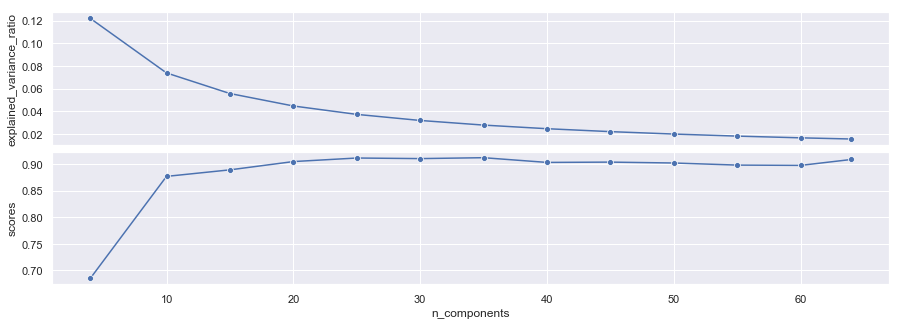

In [89]:
# 繪製不同 components 的 PCA 解釋度
# 繪製不同採樣點的分類正確率
model = search.best_estimator_
components=[4, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
# components=[4,10]
l_scores = list()
l_varatios = list()

for n_component in components:
    pca = PCA(n_components=n_component)
    pca.fit(X_digits)
    newX = pca.transform(X_digits)
    scores = cross_val_score(model, newX, y_digits, cv=5,scoring='accuracy')
    l_scores.append(scores.mean())
    l_varatios.append( pca.explained_variance_ratio_.mean() )
  
                      
df_scores = pd.DataFrame({"n_components": components, "scores":l_scores})
df_varatios = pd.DataFrame({"n_components": components, "explained_variance_ratio":l_varatios})

   
figure, ax = plt.subplots(2,1, figsize=(15,5), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.05)
sns.lineplot(data=df_varatios, x="n_components", y="explained_variance_ratio",err_style="bars" , marker="o", ax=ax[0])
sns.lineplot(data=df_scores, x="n_components", y="scores",  marker="o", ax=ax[1])